# Clusterização da MEIP por Zona OD, considerando ou não a vizinhança

O método proposto vai clusterizar por k-medioides e de maneira hierarquica, primeiramente sem considerar a vizinhança e depois comparando com duas propostas. A primeira adicionando às dimensões, um índice local de Moran para cada dimensão e a outra considerando apenas essa nova dimensão calculada.

Para avaliar os resultados propomos a aplicação do método SHAP para compreender os agrupamentos e a relevância de cada dimensão para cada estratégia utilizada

In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
df_meip = pd.read_csv('data/df_meip.csv', sep=';', decimal=',')\
    .set_index('od_id')

In [3]:
gdf_od = gpd.read_file('data/zonas-OD-2017-São-Paulo.gpkg')

## Dimensões

In [4]:
import seaborn as sns

In [5]:
# demanda = [
#     "prod_desl_pe",
#     "atra_desl_pe",
# ]

# sinistros = [
#     "atrop_tot",
#     "atrop_fer",
#     "atrop_fat",
#     "fatalid"
# ]

# faixas_pedestre = [
#     "faixas_detectadas",
#     "demanda_faixas",
#     "prop_atendida"
# ]

modelo = [
    "desl_pe",
    "atrop_tot",
    "fatalid",
    "prop_atendida",
    "perc_nao_resid",
    "ca_medio",
    "dens_onibus",
    "dens_mass",
    "prop_via_interm",
    "prop_via_rapida"
]

In [6]:
df_meip.columns

Index(['atrop_tot', 'atrop_fer', 'atrop_fat', 'fatalid', 'prod_desl_pe',
       'atra_desl_pe', 'faixas_detectadas', 'demanda_faixas', 'prop_atendida',
       'ext_tot', 'prop_art', 'prop_col', 'prop_loc', 'prop_ped', 'prop_vtr',
       'prop_rod', 'ca_medio', 'perc_comercial', 'perc_residencial',
       'perc_outros_usos', 'dens_onibus', 'dens_mass', 'perc_nao_resid',
       'prop_via_lenta', 'prop_via_interm', 'prop_via_rapida', 'desl_pe'],
      dtype='object')

<AxesSubplot: >

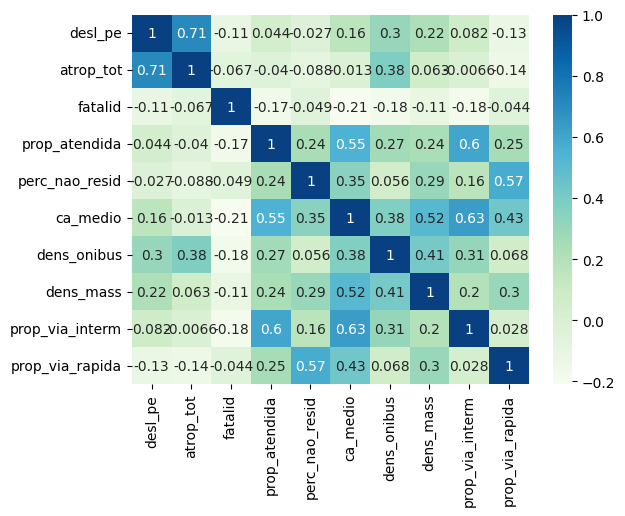

In [7]:
correlacao_modelo = df_meip[modelo].corr()
sns.heatmap(correlacao_modelo, cmap="GnBu", annot=True)

In [8]:
# sns.pairplot(df_meip[modelo])

## K-Clusterização

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline 

In [10]:
scaler = MinMaxScaler((-1,1))
# scaler = StandardScaler()

In [11]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaler.fit_transform(df_meip[modelo]))
    # kmeanModel.fit(scaler.fit_transform(df_meip))
    distortions.append(kmeanModel.inertia_)

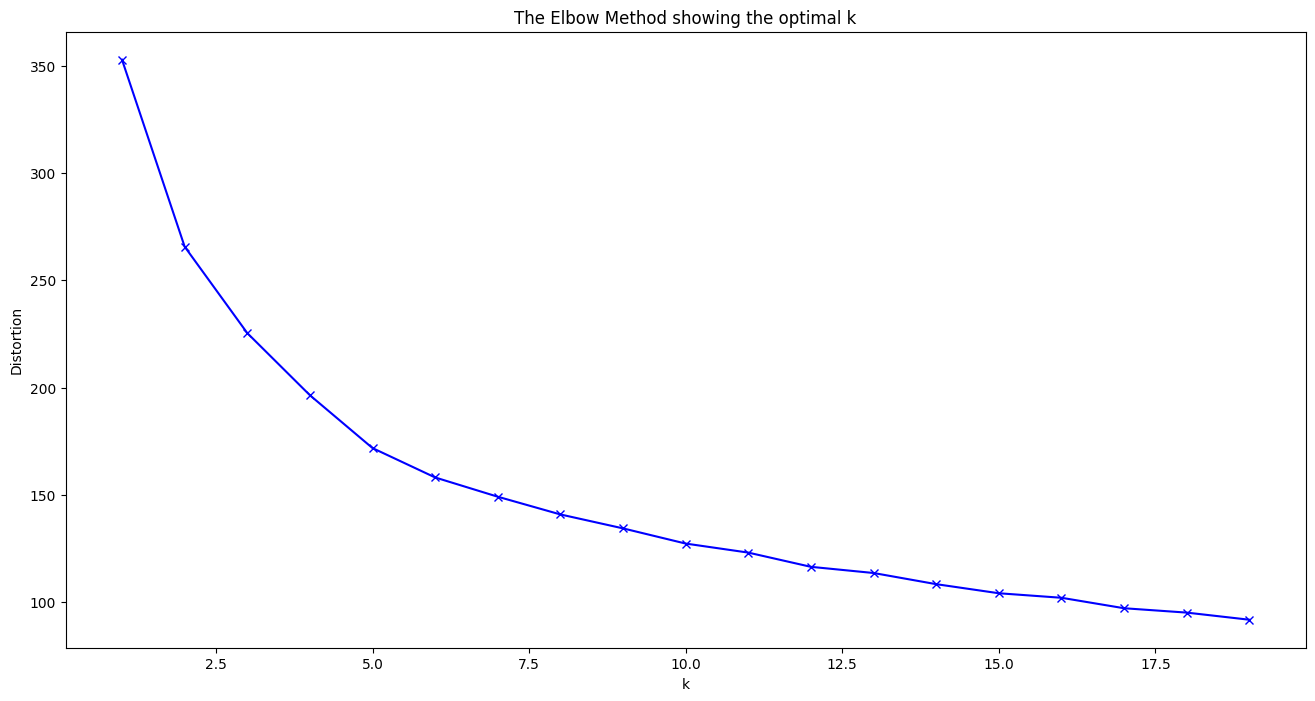

In [12]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<AxesSubplot: >

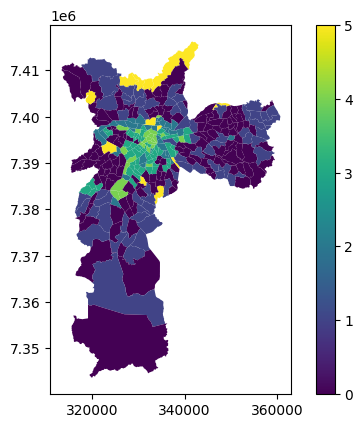

In [98]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(scaler.fit_transform(df_meip[modelo]))
df_meip['k_cluster'] = kmeans.labels_
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_cluster', legend=True)

In [99]:
df_meip.loc[:, modelo + ['k_cluster']].groupby('k_cluster').median().style.background_gradient()

,desl_pe,atrop_tot,fatalid,prop_atendida,perc_nao_resid,ca_medio,dens_onibus,dens_mass,prop_via_interm,prop_via_rapida
k_cluster,,,,,,,,,,
0,111273.000000,37.000000,9.478886,0.080000,11.970000,1.470000,0.210214,0.000000,17.655000,10.540000
1,251201.000000,94.000000,8.689920,0.079500,13.335000,0.975000,0.257558,0.000000,19.610000,7.315000
2,91001.500000,35.000000,7.846154,0.185500,44.880000,3.560000,0.182982,0.000000,19.760000,41.755000
3,116319.000000,32.000000,6.060606,0.237000,21.280000,5.310000,0.225066,0.000000,44.545000,16.970000
4,312108.000000,71.000000,6.666667,0.220000,52.850000,7.070000,0.395830,0.012779,39.650000,33.380000
5,6780.000000,4.000000,0.000000,0.031000,100.000000,0.000000,0.002084,0.000000,1.610000,39.260000


## Clusterização hierarquica

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np

In [15]:
# Z = linkage(df_meip[modelo], 'centroid')
Z = linkage(scaler.fit_transform(df_meip[modelo]), 'ward')

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [45.0, 45.0, 55.0, 55.0],
  [30.0, 30.0, 50.0, 50.0],
  [10.0, 10.0, 40.0, 40.0]],
 'dcoord': [[0.0, 7.022042785123251, 7.022042785123251, 0.0],
  [0.0, 5.711529550310805, 5.711529550310805, 0.0],
  [0.0, 7.425731059406491, 7.425731059406491, 0.0],
  [5.711529550310805, 8.04758235258071, 8.04758235258071, 7.425731059406491],
  [7.022042785123251,
   12.991377288269687,
   12.991377288269687,
   8.04758235258071]],
 'ivl': ['(114)', '(86)', '(8)', '(45)', '(15)', '(74)'],
 'leaves': [673, 676, 669, 674, 672, 677],
 'color_list': ['C1', 'C2', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C2', 'C2', 'C2', 'C2']}

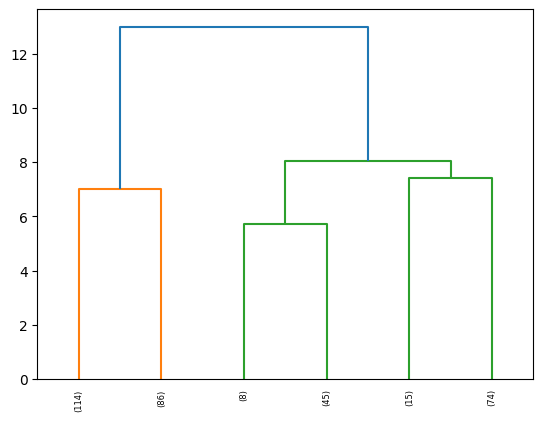

In [16]:
dendrogram(Z, leaf_rotation=90, leaf_font_size=6, labels=df_meip.index, truncate_mode = 'lastp', p=6, show_leaf_counts=True)
# dendrogram(Z, leaf_rotation=90, leaf_font_size=6)

In [17]:
df_meip['h_cluster'] = fcluster(Z, t=6, criterion='maxclust')

In [18]:
np.unique(fcluster(Z, t=6, criterion='maxclust'), return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int32), array([114,  86,   8,  45,  15,  74]))

In [19]:
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')

<AxesSubplot: >

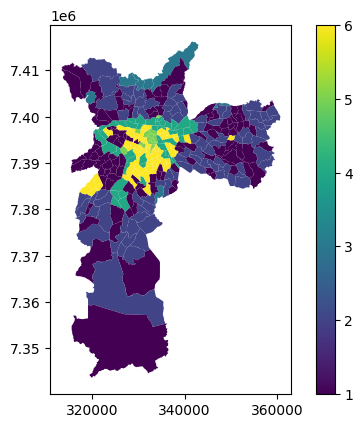

In [20]:
gdf_zona_merged.plot(column='h_cluster', legend=True)

## Matriz de vizinhança

In [21]:
import libpysal as lps

In [22]:
wq = lps.weights.Queen.from_dataframe(gdf_od)

In [23]:
wq.transform = 'r'

In [24]:
for m in modelo:
    df_meip[f'{m}_vizinhos'] = lps.weights.lag_spatial(wq, df_meip[m])

In [25]:
modelo_vizinhanca = modelo + [m + "_vizinhos" for m in modelo]

## Clusterização K+vizinhança

In [26]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaler.fit_transform(df_meip[modelo_vizinhanca]))
    # kmeanModel.fit(scaler.fit_transform(df_meip))
    distortions.append(kmeanModel.inertia_)

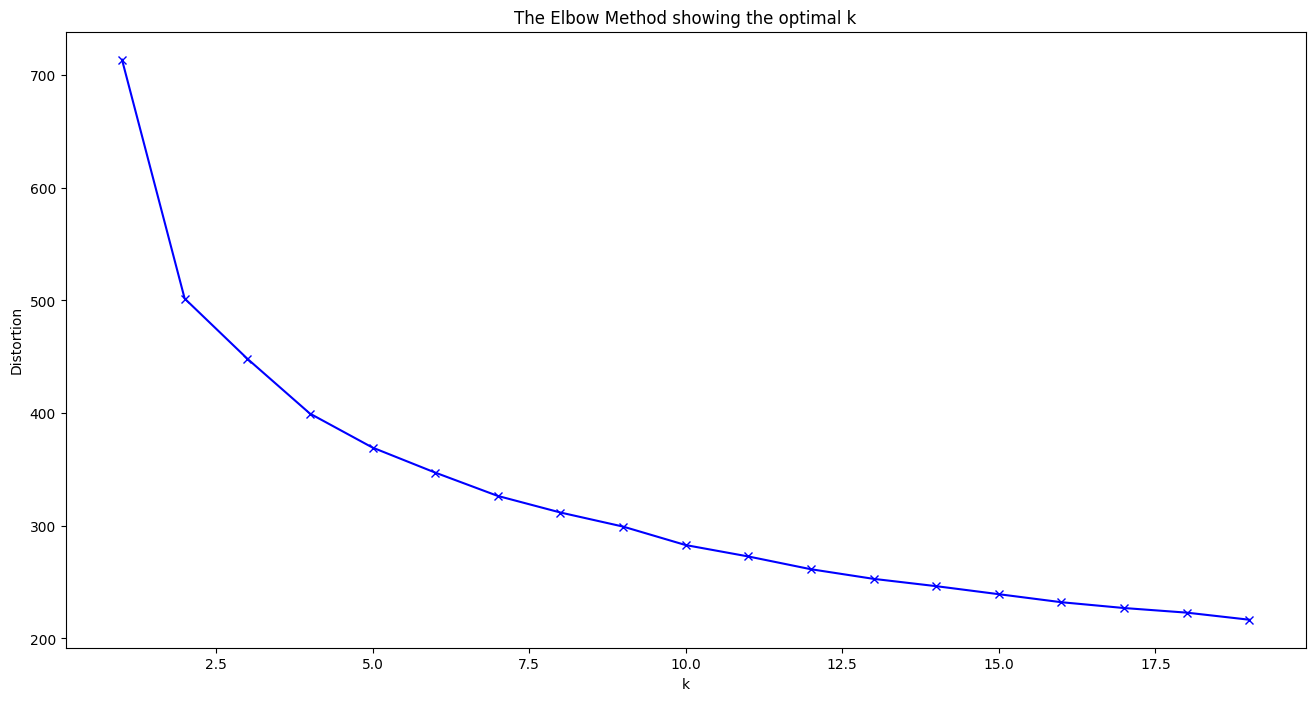

In [27]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<AxesSubplot: >

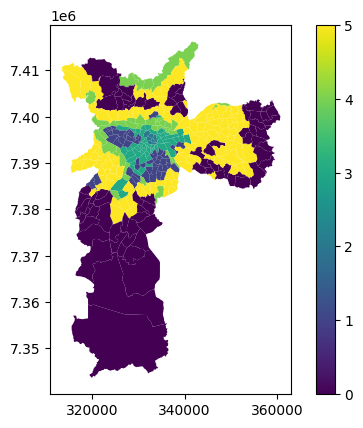

In [111]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(scaler.fit_transform(df_meip[modelo_vizinhanca]))
df_meip['k_cluster'] = kmeans.labels_
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_cluster', legend=True)

In [112]:
df_meip.loc[:, modelo + ['k_cluster']].groupby('k_cluster').quantile(.50).style.background_gradient()

,desl_pe,atrop_tot,fatalid,prop_atendida,perc_nao_resid,ca_medio,dens_onibus,dens_mass,prop_via_interm,prop_via_rapida
k_cluster,,,,,,,,,,
0,223997.000000,81.500000,9.090909,0.067500,11.995000,0.875000,0.240343,0.000000,16.235000,6.170000
1,91775.000000,22.000000,8.333333,0.162000,15.290000,4.330000,0.231108,0.000000,30.840000,15.550000
2,310497.000000,119.000000,9.174312,0.260000,63.620000,11.740000,0.575057,0.017641,35.150000,34.270000
3,181336.000000,48.000000,5.195682,0.228500,37.675000,5.845000,0.223347,0.000000,45.265000,24.280000
4,62003.000000,24.000000,8.000000,0.127000,57.490000,2.940000,0.133077,0.000000,15.320000,43.180000
5,127946.000000,44.000000,8.943089,0.084000,13.350000,1.690000,0.214137,0.000000,18.820000,10.740000


In [80]:
for k in kmeans.labels_:
    df_meip.loc[df_meip['k_cluster'] == k, modelo + ['k_cluster']].describe()

             desl_pe   atrop_tot    fatalid  prop_atendida  perc_nao_resid  \
count       7.000000    7.000000   7.000000       7.000000        7.000000   
mean   339207.142857  131.571429   9.204430       0.237857       64.511429   
std    143527.019603   49.240421   2.374263       0.049677       20.917291   
min    166115.000000   71.000000   6.190476       0.171000       37.060000   
25%    236062.000000   97.500000   7.535014       0.194000       50.750000   
50%    310497.000000  119.000000   9.174312       0.260000       63.620000   
75%    438359.000000  163.000000  10.602747       0.278000       77.530000   
max    548996.000000  210.000000  12.790698       0.290000       94.340000   

        ca_medio  dens_onibus  dens_mass  prop_via_interm  prop_via_rapida  \
count   7.000000     7.000000   7.000000         7.000000         7.000000   
mean   11.821429     0.638808   0.021494        38.621429        33.571429   
std     2.718881     0.154487   0.018687        12.225913      

In [79]:
df_meip.loc[df_meip['k_cluster'] == 2, modelo + ['k_cluster']].describe()

,desl_pe,atrop_tot,fatalid,prop_atendida,perc_nao_resid,ca_medio,dens_onibus,dens_mass,prop_via_interm,prop_via_rapida,k_cluster
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0
mean,339207.142857,131.571429,9.204430,0.237857,64.511429,11.821429,0.638808,0.021494,38.621429,33.571429,2.0
std,143527.019603,49.240421,2.374263,0.049677,20.917291,2.718881,0.154487,0.018687,12.225913,10.574350,0.0
min,166115.000000,71.000000,6.190476,0.171000,37.060000,6.830000,0.491517,0.000000,23.440000,13.070000,2.0
25%,236062.000000,97.500000,7.535014,0.194000,50.750000,11.415000,0.512757,0.009522,32.400000,31.420000,2.0
50%,310497.000000,119.000000,9.174312,0.260000,63.620000,11.740000,0.575057,0.017641,35.150000,34.270000,2.0
75%,438359.000000,163.000000,10.602747,0.278000,77.530000,12.705000,0.757568,0.030556,45.010000,39.230000,2.0
max,548996.000000,210.000000,12.790698,0.290000,94.340000,15.940000,0.864431,0.052663,56.940000,46.360000,2.0


## Clusterização somente da vizinhança

<AxesSubplot: >

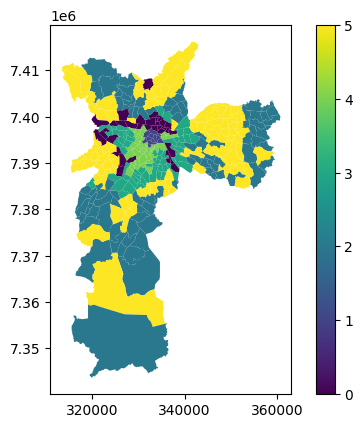

In [29]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(scaler.fit_transform(df_meip[[m + "_vizinhos" for m in modelo]]))
df_meip['k_cluster'] = kmeans.labels_
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_cluster', legend=True)

## Shap

In [37]:
import shap

/home/fernando/dev/meip-sp/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
shap.initjs()

In [58]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_meip[modelo_vizinhanca])

In [68]:
explainer = shap.PartitionExplainer(model=kmeans.predict, masker=shap.maskers.Partition(df_meip[modelo_vizinhanca]))

In [69]:
explainer(df_meip[modelo_vizinhanca])

X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with 

KeyboardInterrupt: 

In [62]:
shap_values = explainer.shap_values(df_meip[modelo_vizinhanca])

  0%|          | 0/342 [00:00<?, ?it/s]X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  0%|          | 1/342 [00:01<10:54,  1.92s/it]X does not have valid feature names, but KMeans was fitted with feature names
X does not have valid feature names, but KMeans was f

KeyboardInterrupt: 

In [52]:
shap.Explainer(kmeans)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KMeans(n_clusters=6, random_state=0)

In [48]:
x_train_summary = shap.kmeans(df_meip[modelo_vizinhanca], 6)
explainer = shap.TreeExplainer(x_train_summary)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'shap.utils._legacy.DenseData'>

In [45]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit_predict(scaler.fit_transform(df_meip[modelo_vizinhanca]))
explainer = shap.KernelExplainer(kmeans, df_meip[modelo_vizinhanca], link="logit")

Provided model function fails when applied to the provided data set.


TypeError: 'KMeans' object is not callable